# ***MONOGRAFÍA: DETECCIÓN DE OPERACIONES DE LAVADO DE ACTIVOS EN ENTIDADES FINANCIERAS***

### **Autor**: Julián Arley Chaverra



# Continuación Notebook 00_EDA_operaciones_sospechosas

Este notebook es la continuación del notebook enunciado y en el cual se desarrollarán varios modelos de clasificación para la identificación de operaciones sospechosas de lavado de activos para determinar cuál de ellos será el mejor.

## Carga de la Información

En esta ocasión se cargarán los datos a los cuales se les aplicó reducción de dimensionalidad en el notebook anterior

In [1]:
# Carga de librerías
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
#Carga de la variable objetivo
Data_Y= pd.read_csv('Data_Y.csv')
Data_Y.drop(columns='Unnamed: 0',inplace=True)

In [3]:
#Cargue de los atributos con reducción de dimensionalidad
Data_X= pd.read_csv('Data_X.csv')
Data_X.drop(columns='Unnamed: 0',inplace=True)

# Modelado de Clasificación

Dado que el problema a resolver se trata de un problema de clasificación que consiste en etiquetar las operaciones bancarias en operaciones normales o sospechosas de lavado de activos, se hace una primera iteración con un modelo de árboles de clasificación y seguidamente se elegirá la métrica adecuada para evaluar la eficiencia del modelo.

En etapas posteriores de este proyecto se evaluarán otros modelos de clasificación más avazados complementados de otras técnicas para compararlos y seleccionar el mejor modelo de clasificación.

## Datos de evaluación y entrenamiento

Recuerda que los datos de este modelo se encuentran desbalanceados, por lo cual, tratando de minimizar el impacto de dicha novedad en los resultados, se estratificará las muestras de entrenamiento y prueba de los modelos.

In [4]:
#Datos de entrenamiento y prueba estratificados

X_train, X_test, y_train, y_test = train_test_split(Data_X,Data_Y,train_size=0.7, stratify=Data_Y, random_state=42)

## Técnica de balanceo de datos

Ya que algunos de los siguientes modelos a utilizar se pueden ver seriamente afectados por el desbalanceo de las clases a predecir, se pueden aplicar diferentes estrategias, a saber:

- Subsampling o submuestras en la clase mayoritaria para reducir esta clase basados en un algoritmo similar al k-nearest neighbor para seleccionar las muestras a eliminar.
- Oversampling o creación de muestras sintéticas para la clase minoritaria.
- Resampling combinado, es decir, una mezcla de las dos estrategias anterioes.

https://www.aprendemachinelearning.com/clasificacion-con-datos-desbalanceados/

Para este caso, dada la proporición del desbalanceo y teniendo en cuenta que el tamaño de la base de datos es demasido grande, lo cual consume mucho recurso tecnológico para la ejecución de los modelos, se aplicará la estrategia de submuestreo sobre la clase mayoritaria, lo cual se consigue ejecutando la siguiente línea de código:

In [5]:
#Instalación de la librería de rebalanceo
!pip install -U imbalanced-learn

#Cargue de las librerías para las estrategias enunciadas anteriormente
from imblearn.under_sampling import NearMiss              #Esta será la que se aplicará a continuación
#from imblearn.over_sampling import RandomOverSampler
#from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier   #Este ensamble se utilizará más adelante

     |████████████████████████████████| 199 kB 4.9 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


In [6]:
#Aplicacíon de la técnica de submuestreo para rebalancear las clases
sub = NearMiss(n_neighbors=3)
X_train_reb, y_train_reb = sub.fit_resample(X_train, y_train)


In [7]:
from numpy.ma.core import count
print ("Distribution before resampling {}".format(y_train.shape))
print ("Distribution after resampling {}".format(y_train_reb.shape))
y_train_reb['Fraude'].sum()

Distribution before resampling (4297645, 1)
Distribution after resampling (10944, 1)


5472

Con el resampleo anterior se logró reducir el set de entrenamiento de 4.297645 registros a 10.944 de los cuales el 50% son operaciones sospechosas de lavado de activos. Es decir, ya tenemos las clases balanceadas para entrenar los modelos que se presentarán a continuación.
La aplicación de esta técnica puede ocasionar que se aumenten los falos negativos, es decir, las operaciones normales clasificadas como sospechosas.

### Modelo1 Árbol de Clasificación

Inicialmente se evaluará el árbol de clasificación con los parámetros que por defecto tiene el objeto DecisionTreeClassifier, es decir, sin indicar la profundidad máxima y con el criterio gini

In [8]:
# Árbol de clasificación
tree= DecisionTreeClassifier(random_state=20)
tree.fit(X_train_reb, y_train_reb)

#Entrenamiento y validación del arbo de decisión
y_train_pred = tree.predict(X_train_reb)
y_test_pred = tree.predict(X_test)

accuracy_train= accuracy_score(y_train_reb,y_train_pred)
accuracy_test= accuracy_score(y_test,y_test_pred)
print(f'La exactitud en Train es de: {accuracy_train}')
print(f'La exactitud en Test es de: {accuracy_test}')

La exactitud en Train es de: 1.0
La exactitud en Test es de: 0.32445891300476476


La iteración anterior da una exactitud en las predicciones casi perfecta tanto sobre los datos de entrenamiento y sobre los datos de prueba del 32%, por lo cual, se tiene un modelo sobreajustado.

Por otra parte, no se ha indicado cuál será la métrica para la evaluación del modelo, ya que el mayor interés de este modelo, más que clasificar correctamente tanto las operaciones normales como las sospechosas, es lograr una alta efectividad en la identificación de operaciones sospechosas, pues es sumamente delicado que ocurra una operación sospechosa y no se identifique como tal, mientras que el impacto de identicar una operación normal como sospechosa no es tan crítico (solo supone una operatividad innecesaria para el banco y un modelo con oportunidades de mejora)

## **Métrica de evaluación**

Con lo mencionado anteriormente, la métrica a utilizar para la selección del mejor modelo, debe ser aquella que permita seleccionar el modelo con mayor efectividad en la identificación de operaciones sospechosas, por lo tanto, la métrica objetivo será la especificidad definida de la siguiente manera:

**Especificidad** (problema biclase) =$$\frac{TN}{TN+FP}$$ = $$\frac{Op_Sosp}{Op_Sosp+Falsas_Op_Norm}$$

**Nota:** Es común hablar de un positivo como una operación sospechosa la cual es el objetivo de este trabajo, pero por la forma como el modelo ordena los datos, las operaciones sospechosas quedan marcadas como negativo y las normales como positivo, por ello la forma en que se enuncia la especificidad.

Pero como se tiene un problema de desbalanceo de datos, también se utilizará la métrica promedio de sensibilidad por clase o Balanced Accuracy

 **Balanced Accuracy (BACC)** = $$\frac{TP}{2(TP + FN)} + \frac{TN}{2(TN + FP)}$$

Ya que no se encontró una librería de Python que permita calcular la especificidad, esta será calculada con la siguiente función:

In [9]:
#Función para calcular la especificidad
def especificidad(confusion_matrix):
  cm= confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[1,0])
  return cm

A continuación se presenta la matriz de confusión para las predicciones con los datos de entrenamiento y los datos de prueba del modelo anterior.

(Text(356.73477272727274, 0.5, 'Clase real'),
 Text(0.5, 6.79999999999999, 'Clase predicción'))

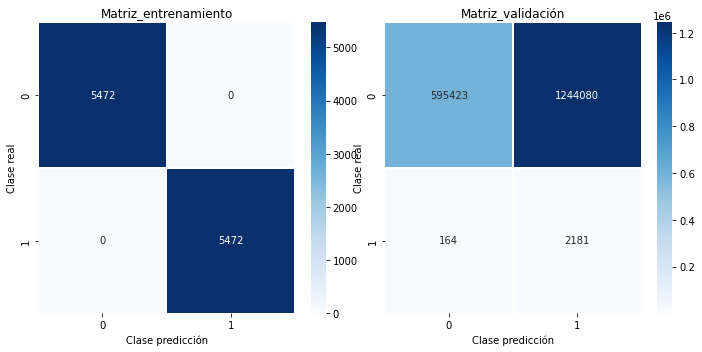

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Matriz de confusión del primer modelo
cm_train= confusion_matrix(y_train_reb,y_train_pred)
cm_test= confusion_matrix(y_test,y_test_pred)

#Plot matriz de confusión
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.heatmap(cm_train,cmap='Blues',cbar=True, annot=True, fmt="d", linewidths=.5)
plt.title("Matriz_entrenamiento"), plt.tight_layout()
plt.ylabel("Clase real"), plt.xlabel("Clase predicción")

plt.subplot(1,2,2)
sns.heatmap(cm_test,cmap='Blues',cbar=True, annot=True, fmt="d", linewidths=.5)
plt.title("Matriz_validación"), plt.tight_layout()
plt.ylabel("Clase real"), plt.xlabel("Clase predicción")

In [13]:
#Cálculo del BACC
from sklearn.metrics import balanced_accuracy_score

#Cálculo de la especificidad
espec_train= especificidad(cm_train)
espec_test= especificidad(cm_test)
print(f'La especificidad en Train es de: {espec_train}')
print(f'La especificidad en Test es de: {espec_test}')

#Cálculo del BACC
BACC_train= balanced_accuracy_score(y_train_reb,y_train_pred)
BACC_test= balanced_accuracy_score(y_test, y_test_pred)
print(f'El BACC en Train es de: {BACC_train}')
print(f'El BACC en Test es de: {BACC_test}')

La especificidad en Train es de: 1.0
La especificidad en Test es de: 0.9300639658848614
El BACC en Train es de: 1.0
El BACC en Test es de: 0.6268754265247461


En los resutlados anteriores y con las métricas de especificidad y BACC, se valida nuevamente un modelo sobreajustado, con una especificidad del 93% en la detección de las operaciones sospechosas y un BACC del 62%.

### Optimización de hiperámetros del modelo1 de clasificación

Debe resaltarse que aún no se tiene certeza de qué valores deben tener los hiperparámetros del modelo de clasificación para obtener lo mejores resultados. Por esta razón, a continuación se aplicará al modelo una técnica de optimizacíon para seleccionar los hiperparámetros.

In [14]:
#Oprtimización de hiperparámetros
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth':np.arange(1, 64),
              'random_state':[20]}

In [15]:
# ESTRATEGIA: Grid Search
tree1= DecisionTreeClassifier()
tree_op = GridSearchCV(tree1, param_grid=param_grid, cv=5, scoring='balanced_accuracy',return_train_score=True)

# Entrenamos: tree con la grilla definida arriba y CV con tamaño de Fold=5
tree_op.fit(X_train_reb, y_train_reb)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]),
                         'random_state': [20]},
             return_train_score=True, scoring='balanced_accuracy')

In [16]:
#Identificación de los mejores hiperparámetors
print("Mejores parametros: "+str(tree_op.best_params_))
print("Mejor Score: "+str(tree_op.best_score_)+'\n')


score=tree_op.cv_results_['mean_train_score']
score

Mejores parametros: {'max_depth': 24, 'random_state': 20}
Mejor Score: 0.9050651540574156



array([0.88559918, 0.88605599, 0.8906704 , 0.89370845, 0.90145295,
       0.90755172, 0.91100149, 0.91652944, 0.92310879, 0.92852256,
       0.93405082, 0.93850526, 0.94346249, 0.94791696, 0.95275997,
       0.95739722, 0.96141769, 0.96520977, 0.97032665, 0.97459841,
       0.97788776, 0.98142854, 0.98369   , 0.98656829, 0.98828151,
       0.99022319, 0.99152517, 0.99294149, 0.99385521, 0.99472328,
       0.99536288, 0.99629938, 0.99680191, 0.99746438, 0.99782992,
       0.99812686, 0.99837811, 0.99865224, 0.99883499, 0.99894917,
       0.99901771, 0.99920047, 0.99933756, 0.99947461, 0.99958884,
       0.99968021, 0.99974874, 0.99977159, 0.99977159, 0.99984011,
       0.99984011, 0.99995432, 0.99997715, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        ])

El mejor árbol de clasificación tiene una profundidad de 24, con lo cual se obtiene una especificidad del 90.8% y una exactitud BACC del 61.5% en las predicciones, y un 97.05% y 98.5% respectivamente en ambas métricas en la etapa de entrenamiento. Muy similar a los resultados anteriores.

Como el modelo optimizado cotinúa siendo un modelo sobreajustado, se llega a la conclusión con esta primera iteración que este árbol de clasificación no es un buen modelo para detectar las operaciones sospechosas de lavado de activos.

La especificidad en Train es de: 0.970577485380117
La especificidad en Test es de: 0.908315565031983
El BACC en Train es de: 0.985014619883041
El BACC en Test es de: 0.614837052949364


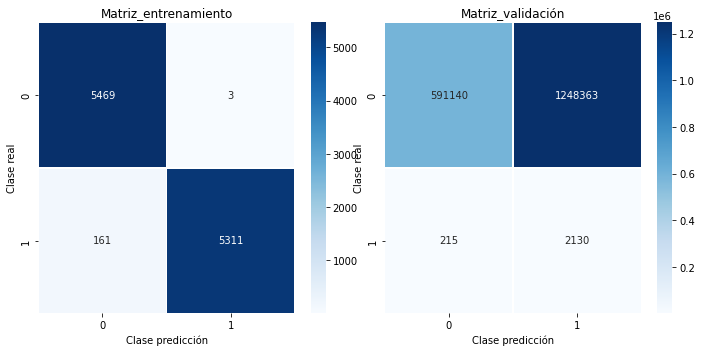

In [17]:
#Evaluación del modelo óptimo
y_train_pred= tree_op.predict(X_train_reb)
y_test_pred= tree_op.predict(X_test)

#Matriz de confusión
cm_train= confusion_matrix(y_train_reb,y_train_pred)
cm_test= confusion_matrix(y_test, y_test_pred)

#Plot matriz de confusión
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.heatmap(cm_train,cmap='Blues',cbar=True, annot=True,fmt="d", linewidths=.5)
plt.title("Matriz_entrenamiento"), plt.tight_layout()
plt.ylabel("Clase real"), plt.xlabel("Clase predicción")

plt.subplot(1,2,2)
sns.heatmap(cm_test,cmap='Blues',cbar=True, annot=True,fmt="d", linewidths=.5)
plt.title("Matriz_validación"), plt.tight_layout()
plt.ylabel("Clase real"), plt.xlabel("Clase predicción")

#Cálculo de la especificidad
espec_train= especificidad(cm_train)
espec_test= especificidad(cm_test)
print(f'La especificidad en Train es de: {espec_train}')
print(f'La especificidad en Test es de: {espec_test}')

#Cálculo del BACC
BACC_train= balanced_accuracy_score(y_train_reb,y_train_pred)
BACC_test= balanced_accuracy_score(y_test, y_test_pred)
print(f'El BACC en Train es de: {BACC_train}')
print(f'El BACC en Test es de: {BACC_test}')

## 2.Modelo Boosting

A continuación entrenaremos un modelo de ensable aplicando la técnica boosting para la obtención de un mejor modelo  de árbol de regresión.

Inicialmente, se realizará un ensamble con 60 árboles y una profundidad por arbol de 1 ya que ha sido lo más recomendable en la literatura.

In [18]:
from sklearn.ensemble import AdaBoostClassifier

In [19]:
#Ensamble con los parámetros iniciales
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, random_state=20),n_estimators=60, algorithm='SAMME.R', random_state=20)

# Entrenamos el modelo
ada_clf.fit(X_train_reb, y_train_reb)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         random_state=20),
                   n_estimators=60, random_state=20)

In [20]:
#Predicción con el modelos ada_clf
y_train_pred = ada_clf.predict(X_train_reb)
y_test_pred = ada_clf.predict(X_test)

(Text(356.73477272727274, 0.5, 'Clase real'),
 Text(0.5, 6.79999999999999, 'Clase predicción'))

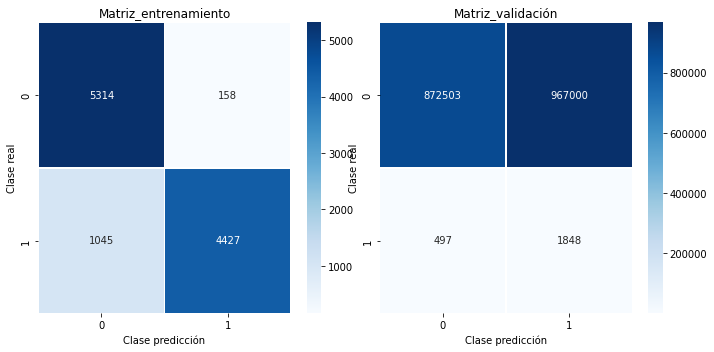

In [21]:
#Matriz de confusión para los datos entrenamiento y de prueba
cm_train= confusion_matrix(y_train_reb,y_train_pred)
cm_test= confusion_matrix(y_test,y_test_pred)

#Plot matriz de confusión
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.heatmap(cm_train,cmap='Blues',cbar=True, annot=True,fmt="d", linewidths=.5)
plt.title("Matriz_entrenamiento"), plt.tight_layout()
plt.ylabel("Clase real"), plt.xlabel("Clase predicción")

plt.subplot(1,2,2)
sns.heatmap(cm_test,cmap='Blues',cbar=True, annot=True,fmt="d", linewidths=.5)
plt.title("Matriz_validación"), plt.tight_layout()
plt.ylabel("Clase real"), plt.xlabel("Clase predicción")

In [22]:
#Cálculo de la especificidad
espec_train= especificidad(cm_train)
espec_test= especificidad(cm_test)
print(f'La especificidad en Train es de: {espec_train}')
print(f'La especificidad en Test es de: {espec_test}')

#Cálculo del BACC
BACC_train= balanced_accuracy_score(y_train_reb,y_train_pred)
BACC_test= balanced_accuracy_score(y_test, y_test_pred)
print(f'El BACC en Train es de: {BACC_train}')
print(f'El BACC en Test es de: {BACC_test}')

La especificidad en Train es de: 0.8090277777777778
La especificidad en Test es de: 0.7880597014925373
El BACC en Train es de: 0.8900767543859649
El BACC en Test es de: 0.6311871155074569


Este modelo de ensamble inicial, es poco menos eficiente ya que ofrece una especificidad del 80.9% y una BACC del 89% aproximadamente en la identificación de operaciones sospechosas en los datos de entrenamiento y un BACC del 63.1% con una especificidad del 78.8% con los datos de prueba. Pero a diferencia del modelo de clasificación anterior, ya no parece un modelo sobreajustado.

A continuación se grafica la especificidad sobre los datos de entrenamiento y los datos de predicción en función del número de árboles, apreciando como los  árboles van aportando a la efectividad del modelo aproximadamente hasta el árbol número 48, a partir del cual, lo otros árboles parecieran no aportar al modelo.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"


Text(0.5, 0, 'Número de árboles')

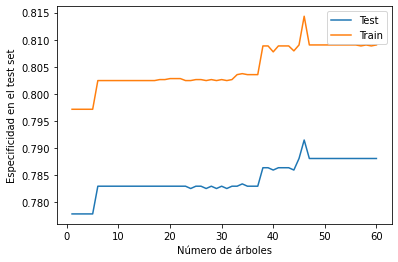

In [23]:
# Definimos listas vacias donde vamos a "appendear" (agregar) los valores
accuracy_test = []
accuracy_train = []

# Calculamos la espcificidad sobre el test set
for prediccion_test in ada_clf.staged_predict(X_test):
    accuracy_test.append(especificidad(confusion_matrix(y_test,prediccion_test)))
    
# Calculamos la espcificidad  sobre el training set    
for prediccion_train in ada_clf.staged_predict(X_train_reb):  
    accuracy_train.append(especificidad(confusion_matrix(y_train_reb,prediccion_train)))
    
plt.plot(range(1, len(accuracy_test) + 1), accuracy_test, label = 'Test')
plt.plot(range(1, len(accuracy_test) + 1), accuracy_train, label = 'Train')
plt.legend()
plt.ylabel('Especificidad en el test set')
plt.xlabel('Número de árboles')

### Optimización de  Hiperparámetros

A continuación se optimizan los hiperparámetros del modelo de ensamble Boosting con un nivel de profundidad del árbol regresor entre 15 y 20 y un rango de estimadores entre 45 y 50 ya que en el gráfico anterior se apercia que la mayor especifidad se obtiene aproximadamente con 48 estimadores.

Impartante que el lector sepa que los anteriores rangos fueron establecidos luego de haber realizado varias iteraciones tratando de acotar los rangos a aplicar a los hiperparámetros, ya que al definir rangos más amplios, los tiempos de ejecución y recursos tecnológicos requeridos son considerables.

In [24]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [25]:
#Estimador y estimador de base
ada_clf_1 = AdaBoostClassifier(DecisionTreeClassifier())


In [26]:
param_grid = {'base_estimator__max_depth': np.arange(15,20),
              'n_estimators':np.arange(45,50),
              'random_state':[20],
              'base_estimator__random_state':[20]}

In [27]:
# ESTRATEGIA 1: Grid Search
model_ada = GridSearchCV(ada_clf_1, param_grid=param_grid, cv=5, scoring='balanced_accuracy',return_train_score=True)

# Entrenamos: el modelo con la grilla definida arriba y CV con tamaño de Fold=5
model_ada.fit(X_train_reb, y_train_reb)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
             param_grid={'base_estimator__max_depth': array([15, 16, 17, 18, 19]),
                         'base_estimator__random_state': [20],
                         'n_estimators': array([45, 46, 47, 48, 49]),
                         'random_state': [20]},
             return_train_score=True, scoring='balanced_accuracy')

In [28]:
#Identificación de los mejores hiperparámetors
print("Mejores parametros: "+str(model_ada.best_params_))
print("Mejor Score: "+str(model_ada.best_score_)+'\n')

score=model_ada.cv_results_['mean_train_score']
score

Mejores parametros: {'base_estimator__max_depth': 17, 'base_estimator__random_state': 20, 'n_estimators': 48, 'random_state': 20}
Mejor Score: 0.9290132979389446



array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

La especificidad en Train es de: 1.0
La especificidad en Test es de: 0.9454157782515992
El BACC en Train es de: 1.0
El BACC en Test es de: 0.6556842147963747


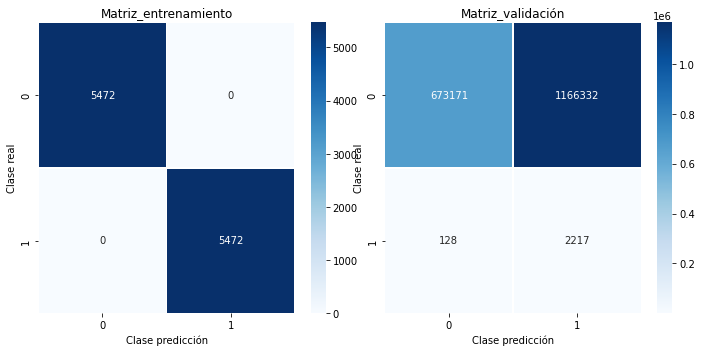

In [29]:
#Evaluación del modelo óptimo
y_train_pred= model_ada.predict(X_train_reb)
y_test_pred= model_ada.predict(X_test)

#Plot matriz de confusión
cm_train= confusion_matrix(y_train_reb,y_train_pred)
cm_test= confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.heatmap(cm_train,cmap='Blues',cbar=True, annot=True,fmt="d", linewidths=.5)
plt.title("Matriz_entrenamiento"), plt.tight_layout()
plt.ylabel("Clase real"), plt.xlabel("Clase predicción")

plt.subplot(1,2,2)
sns.heatmap(cm_test,cmap='Blues',cbar=True, annot=True,fmt="d", linewidths=.5)
plt.title("Matriz_validación"), plt.tight_layout()
plt.ylabel("Clase real"), plt.xlabel("Clase predicción")

#Cálculo de la especificidad
espec_train= especificidad(cm_train)
espec_test= especificidad(cm_test)
print(f'La especificidad en Train es de: {espec_train}')
print(f'La especificidad en Test es de: {espec_test}')

#Cálculo del BACC
BACC_train= balanced_accuracy_score(y_train_reb,y_train_pred)
BACC_test= balanced_accuracy_score(y_test, y_test_pred)
print(f'El BACC en Train es de: {BACC_train}')
print(f'El BACC en Test es de: {BACC_test}')

La optimización mediante GridSearch y validación cruzada indican que el mejor resultado se optiene para una profundidad de 17 en 48 estimadores o árboles en el ensamble, con una especificidad del 94% y un BACC del 65.6% sobre los datos de prueba.

Sin embargo, nuevamente se obtuvo un modelo sobreajustado ya que para los datos de entrenamiento ambas métricas son del 100%.
A continuación se realizará una validación cruzada para corroborar los resultados anteriores.

### Validación Cruzada para el ensamble Boosting

La ejecución de las siguientes líneas de código para evluar el modelo Boosting mediante validación cruzada consume mucho recurso tecnológico y tiempo, razón por la cual para este trabajo no se ejecutará ni será tenido en cuenta para la elección del mejor modelo, pero se dejan las líneas comentariadas para que el lector pueda ejecutarlas y comparar los resultados de la validacón cruzada con los resultados del modelo optimizado.

In [30]:
#from sklearn.model_selection import cross_validate

In [31]:
#Validación cruzada del ensamble del arbol regresor con los parámetros optimizados

# ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=17, random_state=20),n_estimators=48,random_state=20)
# ada_scores = cross_validate(ada, Data_X, Data_Y, cv=5,scoring='balanced_accuracy',return_train_score=True)
# print(ada_scores)

Con los resultados de la validación cruzada se procede a calcular el BAAC promedio para los datos de entrenamiento y de prueba.

In [32]:
#Calculemos el BACC promedio para train y test

# BACC_ada_train=ada_scores['train_score'].mean()
# BACC_ada_test=ada_scores['test_score'].mean()
# print(f'El Balanced_accuracy_train promedio es de:{BACC_ada_train}', f'y el Balanced_accuracy_train promedio es de:{BACC_ada_test}')

## 3.Modelo Bagging Balanceado

Otra estrategia que se puede implementar para la clasificación de las operaciones inusuales con desbalanceo de clases, es el Baggin Balanceado, que consiste en un emsamble robusto de árboles de clasificación para clases desbalanceadas.
A continuación se entrenará este modelo de ensable para comparar sus resultados con los modelos anteriores.

Inicialmente, se realizará un ensamble con los balores que trae por defecto el modelo, es decir, 10 estimadores.

In [33]:
#Ensamble con los parámetros iniciales
bbc_clf = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(), sampling_strategy='auto', replacement=False, random_state=0)

# Entrenamos el modelo
bbc_clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                          random_state=0)

En este modelo, como es especializado para trabajar con clases desbalanceadas, se trabaja con los datos de prueba y entrenamiento originales, es decir, antes del resampleo que se utilizó en los modelos anteriores.

In [34]:
#Predicción con el modelos bbc_clf
y_train_pred = bbc_clf.predict(X_train)
y_test_pred = bbc_clf.predict(X_test)

(Text(352.17227272727274, 0.5, 'Clase real'),
 Text(0.5, 6.79999999999999, 'Clase predicción'))

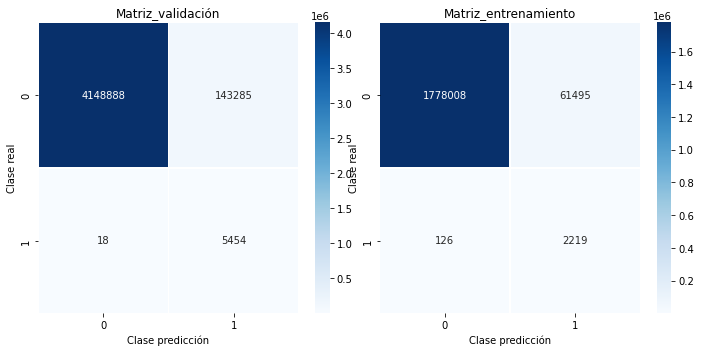

In [35]:
#Matriz de confusión para los datos entrenamiento y de prueba
cm_train= confusion_matrix(y_train,y_train_pred)
cm_test= confusion_matrix(y_test,y_test_pred)

#Plot matriz de confusión
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.heatmap(cm_train,cmap='Blues',cbar=True, annot=True,fmt="d", linewidths=.5)
plt.title("Matriz_validación"), plt.tight_layout()
plt.ylabel("Clase real"), plt.xlabel("Clase predicción")

plt.subplot(1,2,2)
sns.heatmap(cm_test,cmap='Blues',cbar=True, annot=True,fmt="d", linewidths=.5)
plt.title("Matriz_entrenamiento"), plt.tight_layout()
plt.ylabel("Clase real"), plt.xlabel("Clase predicción")

In [36]:
#Cálculo de la especificidad
espec_train= especificidad(cm_train)
espec_test= especificidad(cm_test)
print(f'La especificidad en Train es de: {espec_train}')
print(f'La especificidad en Test es de: {espec_test}')

#Cálculo del BACC
BACC_train= balanced_accuracy_score(y_train,y_train_pred)
BACC_test= balanced_accuracy_score(y_test, y_test_pred)
print(f'El BACC en Train es de: {BACC_train}')
print(f'El BACC en Test es de: {BACC_test}')

La especificidad en Train es de: 0.9967105263157895
La especificidad en Test es de: 0.9462686567164179
El BACC en Train es de: 0.9816638343641346
El BACC en Test es de: 0.9564192156348266


Este modelo de ensamble inicial para clases desbalanceadas arrojó métricas muy buenas, tanto que pareciera haberse obtenido nuevamente un modelo con overfitting o sobreajustado, pues la especificidad es del 99.6% y del 94.6% en los datos de entrenamiento y de prueba, y un BACC del 98.1% y 95.64% respectivamente.

### Optimización de  Hiperparámetros

A continuación se optimizan los hiperparámetros del modelo de ensamble, para lo cual, se optimizará un nivel de profundidad del árbol regresor entre 2 y 20 y un rango de estimadores entre 1 y 11 ya que en el gráfico anterior se apercia que los RMSE obtenidos en el ensamble inicial se estabilizan muy rápido y por último se mantienen las semillas del estimador

In [37]:
#Estimador y estimador de base
bbc_clf_1 =BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(), sampling_strategy='auto', replacement=False)

In [38]:
param_grid = {'base_estimator__max_depth': np.arange(45,48),
              'n_estimators':np.arange(54,57),
              'random_state':[20],
              'base_estimator__random_state':[20]}

In [39]:
# ESTRATEGIA 1: Grid Search
model_bbc = GridSearchCV(bbc_clf_1, param_grid=param_grid, cv=5, scoring='balanced_accuracy',return_train_score=True)

# Entrenamos: el modelo con la grilla definida arriba y CV con tamaño de Fold=5
model_bbc.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

GridSearchCV(cv=5,
             estimator=BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier()),
             param_grid={'base_estimator__max_depth': array([45, 46, 47]),
                         'base_estimator__random_state': [20],
                         'n_estimators': array([54, 55, 56]),
                         'random_state': [20]},
             return_train_score=True, scoring='balanced_accuracy')

In [40]:
#Identificación de los mejores hiperparámetors
print("Mejores parametros: "+str(model_bbc.best_params_))
print("Mejor Score: "+str(model_bbc.best_score_)+'\n')

score=model_bbc.cv_results_['mean_train_score']
score

Mejores parametros: {'base_estimator__max_depth': 46, 'base_estimator__random_state': 20, 'n_estimators': 55, 'random_state': 20}
Mejor Score: 0.9601484014677071



array([0.98037294, 0.97968261, 0.98036403, 0.98037649, 0.97968587,
       0.98036804, 0.98037649, 0.97968587, 0.98036804])

La especificidad en Train es de: 1.0
La especificidad en Test es de: 0.9599147121535181
El BACC en Train es de: 0.9806275282939434
El BACC en Test es de: 0.9606037589366619


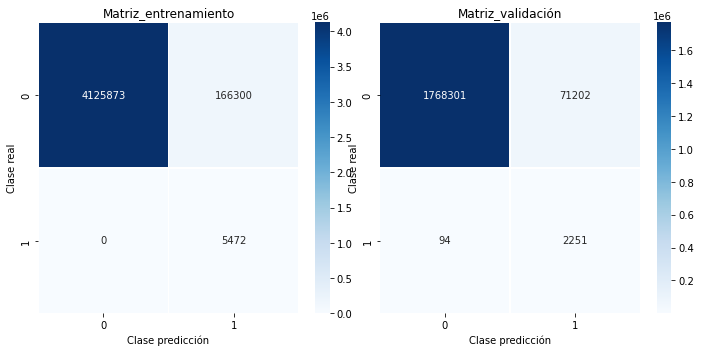

In [41]:
#Evaluación del modelo óptimo
y_train_pred= model_bbc.predict(X_train)
y_test_pred= model_bbc.predict(X_test)

#Plot matriz de confusión
cm_train= confusion_matrix(y_train,y_train_pred)
cm_test= confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.heatmap(cm_train,cmap='Blues',cbar=True, annot=True,fmt="d", linewidths=.5)
plt.title("Matriz_entrenamiento"), plt.tight_layout()
plt.ylabel("Clase real"), plt.xlabel("Clase predicción")

plt.subplot(1,2,2)
sns.heatmap(cm_test,cmap='Blues',cbar=True, annot=True,fmt="d", linewidths=.5)
plt.title("Matriz_validación"), plt.tight_layout()
plt.ylabel("Clase real"), plt.xlabel("Clase predicción")

#Cálculo de la especificidad
espec_train= especificidad(cm_train)
espec_test= especificidad(cm_test)
print(f'La especificidad en Train es de: {espec_train}')
print(f'La especificidad en Test es de: {espec_test}')

#Cálculo del BACC
BACC_train= balanced_accuracy_score(y_train,y_train_pred)
BACC_test= balanced_accuracy_score(y_test, y_test_pred)
print(f'El BACC en Train es de: {BACC_train}')
print(f'El BACC en Test es de: {BACC_test}')

La optimización mediante GridSearch y validación cruzada indican que el mejor resultao se optiene para una profundidad de 46 y 55 estimadores o árboles en el ensamble, con una especificidad del 100% sobre los datos de entreanmiento y del 95% sobre los datos de prueba y un BACC del 98% y 96% respectivamente.

Lo anterior quiere decir que el modelo obtenido se encuentra sobre ajustado, por lo cual, a pesar de ser el modelo óptimo, no sería el más apropiado por el overfitting o sobre ajuste que tiene.

### Validación Cruzada para el ensamble Baggin Balanceado

Al igual que con el ensamble Bossting, se deja al lector las siguientes líneas de código para la validación cruzada del ensamble Bagging Balanceado.

In [42]:
#from sklearn.model_selection import cross_validate

In [43]:
#Validación cruzada del ensamble del arbol regresor con los parámetros optimizados

# bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=46, random_state=20),n_estimators=55,random_state=20, sampling_strategy='auto', replacement=False)
# bbc_scores = cross_validate(bbc, Data_X, Data_Y, cv=5,scoring='balanced_accuracy',return_train_score=True)
# print(bbc_scores)

Con los resultados de la validación cruzada se procede a calcular el BACC promedio del modelo.

In [44]:
#Calculemos el BACC promedio para train y test

# BACC_bbc_train=bbc_scores['train_score'].mean()
# BACC_bbc_test=bbc_scores['test_score'].mean()
# print(f'El Balanced_accuracy_train promedio es de:{BACC_bbc_train}', f'y el Balanced_accuracy_train promedio es de:{BACC_bbc_test}')

## 4.Modelo XGBoost

Por último, se aplicará otro método robusto de clasificación basado en los árboles de ensamble boosting por gradiente (Extreme Gradient Boosting)

A continuación, se instala la librería y se entrena el modelo de clasificación con los valores que trae por defecto la librería.

In [45]:
!pip install xgboost

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-error:0.109649	validation_1-error:0.558048
[1]	validation_0-error:0.109649	validation_1-error:0.558048
[2]	validation_0-error:0.109649	validation_1-error:0.558048
[3]	validation_0-error:0.109649	validation_1-error:0.558048
[4]	validation_0-error:0.109649	validation_1-error:0.558048
[5]	validation_0-error:0.107365	validation_1-error:0.560042
[6]	validation_0-error:0.108553	validation_1-error:0.555852
[7]	validation_0-error:0.108553	validation_1-error:0.556094
[8]	validation_0-error:0.107639	validation_1-error:0.55915
[9]	validation_0-error:0.108553	validation_1-error:0.555868
[10]	validation_0-error:0.107639	validation_1-error:0.559258
[11]	validation_0-error:0.107639	validation_1-error:0.557617
[12]	validation_0-error:0.107639	validation_1-error:0.557391
[13]	validation_0-error:0.107639	validation_1-error:0.557391
[14]	validation_0-error:0.107639	validation_1-error:0.557391
[15]	validation_0-error:0.107639	validation_1-error:0.558738
[16]	validation_0-error:0.107822	va

Text(0.5, 0, 'Número de árboles')

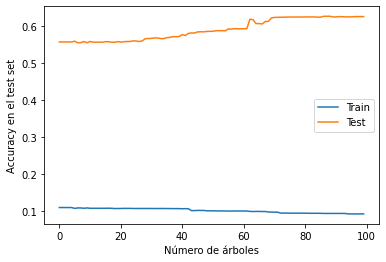

In [46]:
import xgboost as xgb

# XGB Classifier
xg_cl = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree',  seed=0)
eval_set = [(X_train_reb, y_train_reb), (X_test, y_test)]

# Fit the classifier to the training set
xg_cl.fit(X_train_reb, y_train_reb, eval_metric=["error"], eval_set=eval_set, verbose=True)
results = xg_cl.evals_result()

# Predict the labels of the test set (cjto. prueba): preds
predictions = xg_cl.predict(X_test)

# Compute the accuracy: accuracy
accuracy = float(np.sum(predictions == y_test['Fraude']))/y_test.shape[0]
print("accuracy: %f" % (accuracy*100))

# plot classification error
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
plt.legend()
plt.ylabel('Accuracy en el test set')
plt.xlabel('Número de árboles')

En el gráfico anterior se aprecia el error en las predicciones de cada árbol del ensamble, en el cual se aprecia cómo a medida que se aumenta el número de árboles, aumenta el error en los datos de entrenamiento y disminuye en los datos de prueba, pero lo hace de manera leve, por lo cual; se puede suponer que este modelo no se encuetra en sobre o subajuste y que posiblemente el número de árboles estimadores del modelo se puede reducir entre 40 y 50 estimadores aproximadamente.

In [47]:
# Predict the labels of the train set (cjto. prueba): preds
predictions_train = xg_cl.predict(X_train_reb)

(Text(356.73477272727274, 0.5, 'Clase real'),
 Text(0.5, 6.79999999999999, 'Clase predicción'))

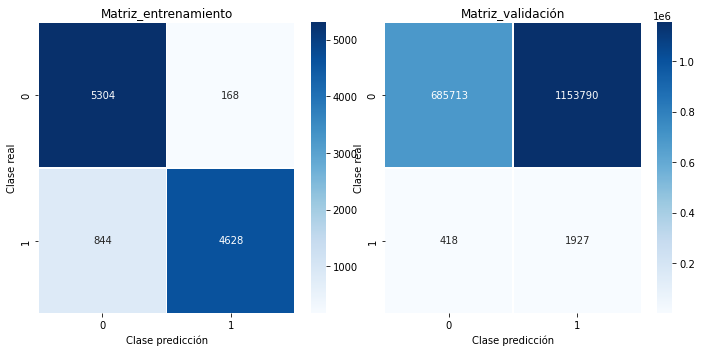

In [48]:
#Matriz de confusión
cm_train= confusion_matrix(y_train_reb,predictions_train)
cm_test= confusion_matrix(y_test, predictions)

#Plot matriz de confusión
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.heatmap(cm_train,cmap='Blues',cbar=True, annot=True,fmt="d", linewidths=.5)
plt.title("Matriz_entrenamiento"), plt.tight_layout()
plt.ylabel("Clase real"), plt.xlabel("Clase predicción")

plt.subplot(1,2,2)
sns.heatmap(cm_test,cmap='Blues',cbar=True, annot=True,fmt="d", linewidths=.5)
plt.title("Matriz_validación"), plt.tight_layout()
plt.ylabel("Clase real"), plt.xlabel("Clase predicción")

In [49]:
#Cálculo de la especificidad
espec_train= especificidad(cm_train)
espec_test= especificidad(cm_test)
print(f'La especificidad en Train es de: {espec_train}')
print(f'La especificidad en Test es de: {espec_test}')

#Cálculo del BACC
BACC_train= balanced_accuracy_score(y_train_reb,predictions_train)
BACC_test= balanced_accuracy_score(y_test, predictions)
print(f'El BACC en Train es de: {BACC_train}')
print(f'El BACC en Test es de: {BACC_test}')

La especificidad en Train es de: 0.8457602339181286
La especificidad en Test es de: 0.8217484008528785
El BACC en Train es de: 0.9075292397660819
El BACC en Test es de: 0.5972595990911873


Con este modelo se logra un modelo aparentemente sin sobreajuste, con una especificidad del 84.6% en los datos de entrenamiento y del 82.1% en los datos de prueba (nada mal!!)
Mientras que el BACC en los datos de entrenamiento y prueba son del 90.7% y 59.7% respectivamente, métrica que tampoco luce mal para el modelo.

## CONCLUSIONES

Al comparar las métricas obtenidas con las métricas de negocio requeridas, estos modelos sólo logran satisfacer la condición de alcanzar una especificidad o BACC mayor al 70% en la identificación de las operaciones inusuales o sospechosas reales, ya que generan altos porcentajes (superiores al 50%) de operaciones normales clasificadas como operaciones sospechosas por el modelo (baja precisión). Esto último resulta costoso operativamente para la entidad financiera en la gestión de dichas falsas operaciones sospechosas.

Por otra parte, el orden en que se ejecutaron los modelos permite observar, cómo para este tipo de problemas, los modelos más sencillos tienden a caer en sobre entrenamiento más fácil que los modelos robustos y a su vez al optimizar los modelos, también aumenta la posibilidad de obtener un sobreentrenamiento del modelo

Por lo tanto, el modelo más recomendado para las entidades financieras en la identificación de operaciones inusuales o sospechosas es el Bagging Balanceado, ya que ofrece una especificidad y BACC de hasta el 96% en la identificación de las operaciones inusuales o sospechosas reales y la menor tasa de falsas operaciones inusuales o sospechosas (precisión del 3% aproximadamente).
